**POZNÁMKA: Tento notebook je určený pre platformu Google Colab, ktorá zdarma poskytuje hardvérovú akceleráciu. Je však možné ho spustiť (možno s drobnými úpravami) aj ako štandardný Jupyter notebook, pomocou lokálnej grafickej karty.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys

!{sys.executable} -m pip install umap-learn

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import os
import pandas as pd
import numpy as np
import numbers

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from umap import UMAP
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p output
!mkdir -p data/fruits
!wget -nc -O data/fruits.zip https://www.dropbox.com/s/v5ewkye4cc5huz9/fruits.zip?dl=1
!unzip -oq -d data/fruits data/fruits.zip
!wget -nc -O data/iris.csv https://www.dropbox.com/s/v3ptdkv5fvmx5zk/iris.csv?dl=1

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
data_dir = "data/fruits"

def load_fruit(dir, fname):
    img = image.load_img(os.path.join(data_dir, dir, fname),
                         target_size=(224, 224))
    img = image.img_to_array(img)

    return img
  
def load_fruit_data(data_dir=data_dir):
    dirs = (it for it in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, it)))
    file_dir = {}

    for d in dirs:
        ddir = os.path.join(data_dir, d)
        filenames = []

        for f in (it for it in os.listdir(ddir) if os.path.isfile(os.path.join(ddir, it))):
            filenames.append(os.path.join(ddir, f))

        file_dir[d] = filenames
  
    data = []
    labels = []

    for fruit, images in file_dir.items():
        for img_path in images:
            img = image.load_img(img_path, target_size=(224, 224))
            img = image.img_to_array(img)
            data.append(img)
            labels.append(fruit)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

cmap = 'viridis'

def make_cmap_fruit(class_names):
    fruit_dict = {'apples': 'r', 'kiwis': 'g', 'oranges': 'orange'}
    cmap_fruit = ListedColormap([fruit_dict[f] for f in class_names])
    return cmap_fruit

def plot_data(data, colors, alpha=1.0, ax=None,
              edgecolors=None, cmap=cmap, s=50):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(data[:, 0], data[:, 1], s=s,
               c=colors, edgecolors=edgecolors,
               alpha=alpha, cmap=cmap)

    ax.grid(ls='--')
    ax.set_axisbelow(True)
    ax.set_xlabel("$d_1$")
    ax.set_ylabel("$d_2$")
    
def make_legend(class_names, cmap=cmap, ax=None):
    if ax is None:
        ax = plt.gca()
  
    cm = plt.get_cmap(cmap, len(class_names))

    legend_handles = []
    for ic, cn in enumerate(class_names):
        legend_handles.append(
            mpatches.Patch(color=cm(ic), label=cn)
        )

    ax.legend(handles=legend_handles)
    
def show_text(text, ax, fontsize=14):
    ax.text(0.5, 0.5, text, horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes,
            fontsize=fontsize)
    ax.axis("off")
    
def imscatter(x, y, images, ax=None, zoom=1,
              frame_cmap=None, frame_c=None,
              frame_linewidth=1, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    if isinstance(frame_cmap, str):
        frame_cmap = plt.cm.get_cmap(frame_cmap)
    elif frame_cmap is None:
        frame_cmap = plt.cm.get_cmap('jet')
    
    if len(images) == 1:
        images = [images[0] for i in range(len(x))]
        
    if frame_c is None:
        frame_c = ['k' for i in range(len(x))]

    x, y = np.atleast_1d(x, y)
    artists = []
    
    for i, (x0, y0) in enumerate(zip(x, y)):
        fc = frame_c[i]
        if isinstance(fc, numbers.Number):
            fc = frame_cmap(fc)
      
        im = OffsetImage(images[i], zoom=zoom, **kwargs)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True,
                            bboxprops=dict(edgecolor=fc,
                                           linewidth=frame_linewidth))
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists

## Lokálne a globálne zovšeobecnenie a predtrénované embedovania

V predchádzajúcich notebookoch sme ukázali, ako metóda $k$ najbližších susedov (KNN) funguje, a ako sa dá aplikovať na détovú množinu Iris. Ukázali sme tiež, ako sá dá prostredníctvom vyhodnotenia správnosti na testovacích dátch overiť, či výsledný model zovšeobecňuje.

### Metódy založené na vzdialenosti a lokálne zovšeobecnenie

Ako už vieme, pri predikcii vystúpov pre nové dáta, vychádza KNN zo vzdialeností medzi novými bodmi a existujúcimi bodmi v dátovej množine. Tento prístup funguje prijateľne dobre, ak použitá miera vzdialenosti vypovedá o sémantickej podobnosti, t.j. ak meria taký typ vzdialenosti, o ktorý máme záujem.

V prípade dátovej množiny Iris to evidentne platí – keď dáta vizualizujeme v 2D, vidíme, že body zodpovedajúce jednotlivým triedam sú (z väčšej časti) veľmi pekne zoskupené. Vykreslime príslušnú vizualizáciu znovu, aby sme si osviežili pamäť.



In [ ]:
df = pd.read_csv("data/iris.csv")
data_raw = df.iloc[:, :-1]
umap = UMAP(spread=20.0)
data = umap.fit_transform(data_raw)

str_labels = df[['species']].values
ordenc = OrdinalEncoder(dtype='int')
num_labels = ordenc.fit_transform(str_labels).flatten()
class_names = ordenc.categories_[0]

plot_data(data, num_labels)
make_legend(class_names)

S dátami tohto typu KNN typicky funguje dobre. Typ zovšeobecnenia, ktoré poskytuje, sa niekedy označuje ako **lokálne zovšeobecnenie**  pretože vychádza z predpokladu, že predikcie pre vzorky, ktoré sú si vo vstupnom priestore blízko, by mali vo všeobecnosti byť podobné. Tento predpoklad však neplatí pre všetky dátové množiny a pre všetky miery vzdialenosti.

### Pixelová vzdialenosť medzi obrázkami nie je indikátor sémantickej podobnosti

Dobrým príkladom toho, kedy jednoduchá vzdialenostná metrika (napr. v zmysle euklidovskej vzdialenosti) nie je dobrým indikátorom podobnosti, sú obrázky. Pozrime sa teraz na malú dátovú množinu skladajúcu sa z obrázkov ovocia – umožní nám to tento problém preskúmať pomocou skutočných dát. Najprv niekoľko obrázkov z tejto množiny vykreslime, aby sme získali predstavu, ako približne vyzerajú:



In [ ]:
# Load the data.
data, labels = load_fruit_data()

# Show a few randomly selected samples.
num_rows = 4; num_cols = 5
index = np.random.permutation(len(data))[:num_rows*num_cols]
index = index.reshape(num_rows, num_cols)
fig, axes = plt.subplots(num_rows, num_cols)
fig.set_size_inches(8, 6)
plt.subplots_adjust(hspace=0, wspace=0)

for ax_row, ind_row in zip(axes, index):
    for ax, ind in zip(ax_row, ind_row):
        ax.imshow(data[ind].astype(int))
        ax.axis("off")
        
plt.savefig("output/fruit_data.pdf", bbox_inches='tight', pad_inches=0)

Terz si nejaké obrázky vyberme a porovnajme vzdialenosti medzi nimi. Konkrétne:

* Vzdialenosť medzi dvoma obrázkami jablka $d_{\text{apple 1}, \text{apple 2}}$;
* Vzdialenosť medzi obrázkom jablka a obrázkom pomaranča $d_{\text{apple 1},\text{orange}}$.
Obrázky najprv načítame:



In [ ]:
img1 = load_fruit("apples", "apple2.jpeg").astype('int')
img2 = load_fruit("apples", "apple19.jpg").astype('int')
img3 = load_fruit("oranges", "orange12.jpg").astype('int')

Ďalej medzi nimi určíme pixelovú euklidovskú vzdialenosť (t.j. vypočítame rozdiel medzi obrázkami a aplikujeme L2 normu):



In [ ]:
img1_vs_img2 = np.linalg.norm(img1 - img2)
img1_vs_img3 = np.linalg.norm(img1 - img3)

Výsledky vykreslíme:



In [ ]:
fig, axes = plt.subplots(2, 4, gridspec_kw={'width_ratios': [3, 1, 3, 1]})
fig.set_size_inches(9, 7)

# img1 vs. img2
ax = axes[0, 0]; ax.imshow(img1); ax.axis("off")
ax = axes[0, 1]; show_text("vs.", ax)
ax = axes[0, 2]; ax.imshow(img2); ax.axis("off")
ax = axes[0, 3]; show_text("= {:.2f}".format(img1_vs_img2), ax)

# img1 vs. img3
ax = axes[1, 0]; ax.imshow(img1); ax.axis("off")
ax = axes[1, 1]; show_text("vs.", ax)
ax = axes[1, 2]; ax.imshow(img3); ax.axis("off")
ax = axes[1, 3]; show_text("= {:.2f}".format(img1_vs_img3), ax)

plt.savefig("output/fruit_distances.pdf", bbox_inches='tight', pad_inches=0)

Ako vidno, v našom prípade vzdialenosť $d_{\text{apple 1},\text{apple 2}}$ medzi dvoma obrázkami jabĺk je v skutočnosti podstatne väčšia než vzdialenosť $d_{\text{apple 1},\text{orange}}$ medzi obrázkom jablka a obrázkom pomaranča. Je to tak samozrejme preto, že pozadie druhých dvoch obrázkov je mnoho podobnejšie (biele) a tvorí väčšiu časť celkovej plochy než samotné ovocie.

Keby však aj pozadia boli podobné, stále by sme čelili iným problémom, pretože v prirodzených obrázkoch je obrovské množstvo variability – objekty môžu mať rôzne farby, tvary, počty, veľkosti, pozície, svetelné podmienky a pod. Preto v tomto prípade lokálne zovšeobecnenie jednoducho nestačí.

### Vykreslenie obrázkov ovocia v 2D

Aby sme si naozaj uvedomili, v čom je problém, zobrazíme si teraz obrázky ovocia v 2D, podobne ako sme to urobili so vzorkami z dátovej množiny Iris. Toto nám umožní porovnať vzdialenosti medzi rozličnými vzorkami a posúdiť, akým spôsobom sú zoskupené.



In [ ]:
# Convert string labels to numbers.
output_preproc = OrdinalEncoder()
Y = output_preproc.fit_transform(labels.reshape(-1, 1)).flatten().astype(int)
class_names = output_preproc.categories_[0]
# Reduce dimensionality to 2 using UMAP.
umap1 = UMAP()
raw_embeds = umap1.fit_transform(data.reshape((data.shape[0], -1)))
# Plot the results
cmap_fruit = make_cmap_fruit(class_names)
plot_data(raw_embeds, Y, cmap=cmap_fruit)
make_legend(class_names, cmap=cmap_fruit)

plt.savefig("output/fruit_umap.pdf", bbox_inches='tight', pad_inches=0)

Čo vidíme okamžite, je, že obrázky zodpovedajúce rozličným druhom ovocia sú značne premiešané – bolo by veľmi ťažké ich od seba v tomto priestore oddeliť. KNN – alebo ľubovoľná iná metóda založená na lokálnom zovšeobecnení – nebude na takejto úlohe dobre fungovať, pretože lokálne vzdialenosti nie sú indikátorom toho typu sémantickej podobnosti, ktorý je v tomto prípade relevantný.

### Globálne zovšeobecnenie

Na úlohy s komplexnými, neštruktúrovanými dátami ako sú obraz, zvuk, text a pod. metódy založené na lokálnych vzdialenostiach typicky nestačia. Aby systém dobre fungoval, musí byť schopný porozumieť štruktúru dát a nejakým spôsobom ju extrahovať.

Metódy strojového učenia neboli tradične schopné extrahovať túto štruktúru automaticky. Namiesto toho bolo potrebné vykonať veľký objem výskumnej a inžinierskej práce, aby sa vyvinuli a implementovali zložité metódy predspracovania, ktoré z dát extrahovali užitočné príznaky. Pri použití týchto príznakov (lepšie štruktúrovanej reprezentácie) boli už aj metódy poskutujúce len lokálne zovšeobecnenie schopné dosiahnuť prijateľné výsledky.



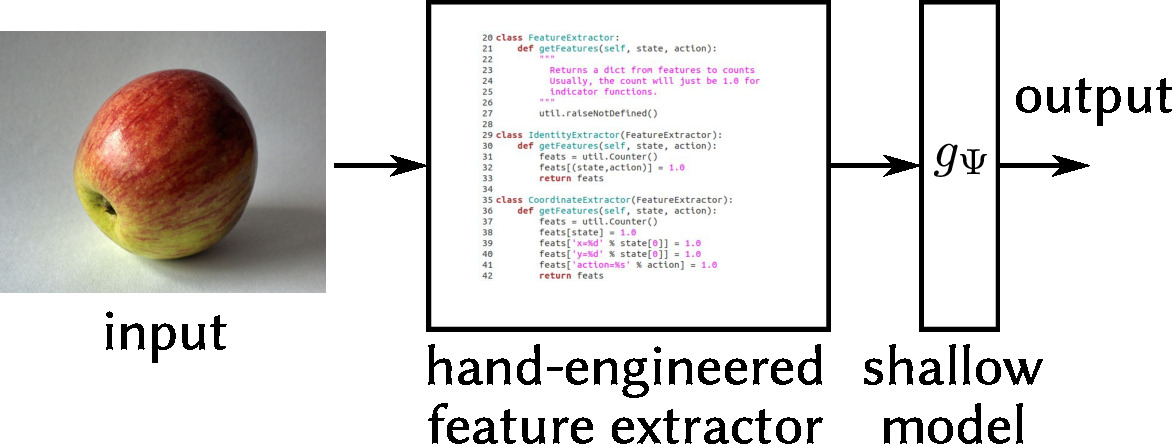



So zavedením hlbokého učenia sa tento prístup zmenil. Hlboké učenie je schopné naučiť sa extrahovať užitočné príznaky automaticky, takže táto fáza algoritmu sa už nemusí navrhovať ručne. Namiesto ručne navrhnutého predspracovania sa použije umelá neurónová sieť s veľkým počtom vrstiev. Sieť sa postupne naučí, ako použiť prvý vrstvy na predspracovanie dát, zatiaľ čo neskoršie vrstvy budú fungovať podobne ako štandardný plytký klasifikátor (vlastne by sa *dali*  nahradiť aj jednoduchou metódou ako je KNN). V každom prípade vďaka tejto schopnosti predspracovať si dáta a extrahovať z nich štruktúru, vedia hlboké neurónové siete vykonávať **globálne zovšeobecnenie** .



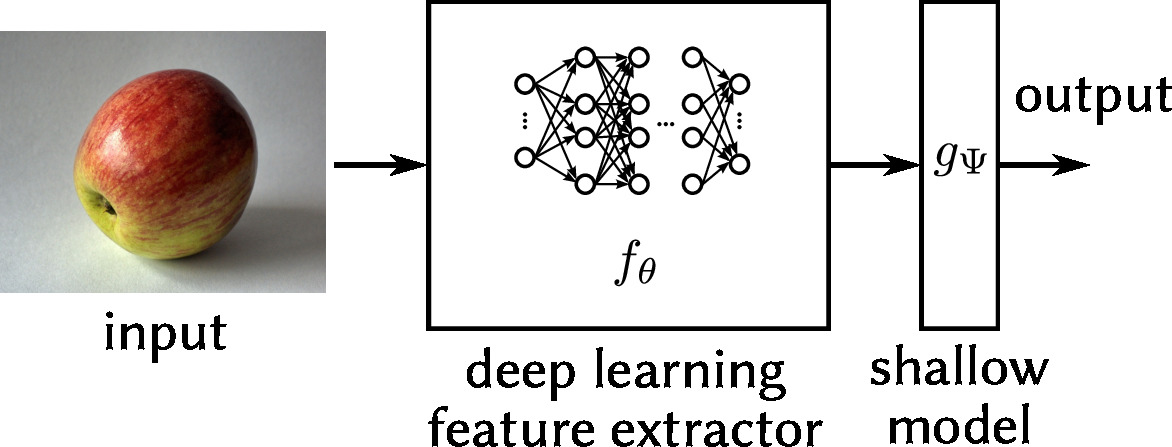



Aby sme lepšie ilustrovali, čo môže hlboký klasifikátor s dátami urobiť a ako môže ovplyvniť štruktúru priestoru, transformujeme teraz našu dátovú množinu pomocou siete predtrénovanej na dátovej množine ImageNet. Úlohou ná tejto dátovej množine je klasifikovať prirodzené obrázky. Dá sa preto očakávať, že náš extraktor príznakov bude body z pôvodného priestoru transformovať do priestoru, kde body patriace do tej istej triedy budú zoskupené spôsobom, ktorý plytkému modelu (so schopnosťou lokálne zovšeobecňovať) uľahčí ich správne klasifikovať.

V prvom kroku aplikujeme na obrázky triviálne predspracovanie, aby sme ich transformovali do podoby, ktorú očakáva náš extraktor príznakov. Následne aplikujeme aj samotný extraktor (používame architektúru ResNet50 – konkrétne výstup predposlednej vrstvy):



In [ ]:
data_preproc = preprocess_input(data.copy())
resnet = ResNet50(weights='imagenet')
extractor = Model(resnet.input, resnet.layers[-2].output)
feat_vec = extractor.predict(data_preproc).reshape((data_preproc.shape[0], -1))

V ďalčom kroku aplikujeme metódu UMAP, aby sme tento nový priestor vizualizovali v 2D. Mali by sme vidieť, že jednotlivé triedy budú teraz rozdelené do celkom pekných zhlukov. Pre plytké metódy ako KNN bude s touto novou reprezentáciou omnoho jednoduchšie pracovať.



In [ ]:
umap2 = UMAP()
feat_embeds = umap2.fit_transform(feat_vec)

In [ ]:
plot_data(feat_embeds, Y, cmap=cmap_fruit)
make_legend(class_names, cmap=cmap_fruit)
plt.savefig("output/fruit_resnet_umap.pdf", bbox_inches='tight', pad_inches=0)

Aby sme získali lepšiu predstavu o tom, ako sú dáta zoskupené v rámci zhlukov, môžeme namiesto jednoduchých bodov vykresliť aj samotné obrázky:



In [ ]:
plt.figure(figsize=[12, 8])
imscatter(feat_embeds[:, 0], feat_embeds[:, 1],
          data.astype('int'), zoom=0.2,
          frame_c=Y, frame_cmap=cmap_fruit,
          frame_linewidth=2)

plt.grid(ls='--')
plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.savefig("output/fruit_resnet_imscatter.pdf", bbox_inches='tight', pad_inches=0)